In [63]:
# Import Dependencies
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import os

In [64]:
# Set up Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# Change Directory
%cd /content/drive/MyDrive/pet_expressions_data

/content/drive/MyDrive/pet_expressions_data


In [66]:
# Define the path to the dataset folders
happy_folder = "/content/drive/MyDrive/pet_expressions_data/happy"
sad_folder = "/content/drive/MyDrive/pet_expressions_data/sad"
angry_folder = "/content/drive/MyDrive/pet_expressions_data/angry"
#other_folder = "/content/drive/MyDrive/pet_expressions_data/other"

In [67]:
# Check the number of pictures in each 'emotion' folder, ideally we would want this to be equal
# Define function to count picturues within a folder, takes path as input

def count_pics(folder_path):
    picture_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    picture_count = 0

    # Check if the provided folder path exists
    if not os.path.exists(folder_path):
        print("Folder path does not exist.")
        return 0

    # Get a list of files in the folder
    files = os.listdir(folder_path)

    # Count pictures with valid extensions
    for file in files:
        _, extension = os.path.splitext(file)
        if extension.lower() in picture_extensions:
            picture_count += 1

    return picture_count

In [68]:
# Happy
happy_picture_count = count_pics(happy_folder)
print(f"Number of pictures in the HAPPY folder: {happy_picture_count}")

Number of pictures in the HAPPY folder: 112


In [69]:
# Sad
sad_picture_count = count_pics(sad_folder)
print(f"Number of pictures in the SAD folder: {sad_picture_count}")

Number of pictures in the SAD folder: 105


In [70]:
# Angry
angry_picture_count = count_pics(angry_folder)
print(f"Number of pictures in the ANGRY folder: {angry_picture_count}")

Number of pictures in the ANGRY folder: 94


In [71]:
 # Other
 #other_picture_count = count_pics(other_folder)
#print(f"Number of pictures in the  OTHER folder: {other_picture_count}")

In [72]:
# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48, 48))  # Resize to a fixed size for the model
            images.append(img)
    return images

In [73]:
# Load images and labels for each emotion
happy_images = load_images_from_folder(happy_folder)
sad_images = load_images_from_folder(sad_folder)
angry_images = load_images_from_folder(angry_folder)
#other_images = load_images_from_folder(other_folder)

In [74]:
# Create labels for each emotion category
happy_labels = [0] * len(happy_images)
sad_labels = [1] * len(sad_images)
angry_labels = [2] * len(angry_images)
#other_labels = [3] * len(other_images) # 3???? not sure if thats correct

In [75]:
# Concatenate images and labels
x = np.array(happy_images + sad_images + angry_images)
y = np.array(happy_labels + sad_labels + angry_labels)

In [76]:
# Normalize pixel values to range [0, 1]
x = x.astype('float32') / 255.0

In [77]:
# One-hot encode the labels
y = tf.keras.utils.to_categorical(y, 3)

In [78]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

In [100]:
# Data pre-processing - resizing images to specific shapes for model input

input_shape_resnet = (224, 224, 3)
input_shape_densenet = (224, 224, 3)
input_shape_efficientnet = (224, 224, 3)

# Function to resize pictures to variable shapes defined above
def resize_pics(images, input_shape):
    resized_images = []
    for img in images:
        img_resized = cv2.resize(img, (input_shape[0], input_shape[1]))
        img_resized = np.expand_dims(img_resized, axis=-1)
        img_resized = np.repeat(img_resized, 3, axis=-1)  # Add three channels to convert grayscale to RGB
        resized_images.append(img_resized)
    return np.array(resized_images)

# Utilize function above to resize data
x_train_resized_resnet = resize_pics(x_train, input_shape_resnet)
x_train_resized_densenet = resize_pics(x_train, input_shape_densenet)
x_train_resized_efficientnet = resize_pics(x_train, input_shape_efficientnet)

In [101]:
# Fit ResNet Model
# Load pre-trained ResNet50 model and remove the top classification layer
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_resnet)
resnet_base_model.trainable = False

In [81]:
# Add custom classification head to the ResNet model
resnet_global_avg_pooling = GlobalAveragePooling2D()(resnet_base_model.output)
resnet_output = Dense(3, activation='softmax')(resnet_global_avg_pooling)
resnet_model = Model(inputs=resnet_base_model.input, outputs=resnet_output)

In [82]:
# Compile the ResNet model
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [102]:
# Fit DenseNet Model
densenet_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape_densenet)
densenet_base_model.trainable = False

In [107]:
# Add custom classification head to the DenseNet model
densenet_global_avg_pooling = GlobalAveragePooling2D()(densenet_base_model.output)
densenet_output = Dense(3, activation='softmax')(densenet_global_avg_pooling)
densenet_model = Model(inputs=densenet_base_model.input, outputs=densenet_output)

In [104]:
# Compile the DenseNet model
densenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [108]:
# Fit EfficientNet model
efficientnet_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape_efficientnet)
efficientnet_base_model.trainable = False

In [109]:
# Add custom classification head to the EfficientNet model
efficientnet_global_avg_pooling = GlobalAveragePooling2D()(efficientnet_base_model.output)
efficientnet_output = Dense(3, activation='softmax')(efficientnet_global_avg_pooling)
efficientnet_model = Model(inputs=efficientnet_base_model.input, outputs=efficientnet_output)

In [110]:
# Complile the EfficientNet Model
efficientnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [111]:
# Establish early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-7)

In [92]:
# Train the models on resized training data and validation split,monitoring the validation loss and using the early stopping and learning rate scheduling callbacks to stop when necessary.
######EPOCS ARE ONLY SET TO 5 WARNING: LONG RUN TIME####

resnet_history = resnet_model.fit(x_train_resized_resnet, y_train, batch_size=64, epochs=5, validation_split=0.1,callbacks=[early_stopping, lr_scheduler])
densenet_history = densenet_model.fit(x_train_resized_densenet, y_train, batch_size=64, epochs=5, validation_split=0.1,callbacks=[early_stopping, lr_scheduler])
efficientnet_history = efficientnet_model.fit(x_train_resized_efficientnet, y_train, batch_size=64, epochs=5, validation_split=0.1,callbacks=[early_stopping, lr_scheduler])

Epoch 1/5
4/4 [==============================] - 46s 11s/step - loss: 1.0874 - accuracy: 0.3946 - val_loss: 1.0844 - val_accuracy: 0.3200 - lr: 0.0010
Epoch 2/5
4/4 [==============================] - 45s 11s/step - loss: 1.0871 - accuracy: 0.4484 - val_loss: 1.0944 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/5
4/4 [==============================] - 45s 11s/step - loss: 1.0781 - accuracy: 0.4529 - val_loss: 1.0743 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 4/5
4/4 [==============================] - 49s 13s/step - loss: 1.0795 - accuracy: 0.3901 - val_loss: 1.0623 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 5/5
4/4 [==============================] - 45s 11s/step - loss: 1.0796 - accuracy: 0.4170 - val_loss: 1.0878 - val_accuracy: 0.3200 - lr: 0.0010
Epoch 1/5
4/4 [==============================] - 57s 13s/step - loss: 1.5849 - accuracy: 0.3453 - val_loss: 0.9864 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 2/5
4/4 [==============================] - 43s 11s/step - loss: 1.2069 - accuracy: 0.403

In [95]:
# Resize test images to the input shape required by each model
x_test_resized_densenet = resize_pics(x_test, input_shape_densenet)
x_test_resized_resnet = resize_pics(x_test, input_shape_resnet)
x_test_resized_efficientnet = resize_pics(x_test, input_shape_efficientnet)

In [97]:
# Evaluate the models on test data
densenet_loss, densenet_accuracy = densenet_model.evaluate(x_test_resized_densenet, y_test)
resnet_loss, resnet_accuracy = resnet_model.evaluate(x_test_resized_resnet, y_test)
efficientnet_loss, efficientnet_accuracy = efficientnet_model.evaluate(x_test_resized_efficientnet, y_test)

print("\n")
print("DenseNet Test accuracy:", densenet_accuracy)
print("ResNet Test accuracy:", resnet_accuracy)
print("EfficientNet Test accuracy:", efficientnet_accuracy)

2/2 [==============================] - 4s 2s/step - loss: 1.1801 - accuracy: 0.2540


DenseNet Test accuracy: 0.4444444477558136
ResNet Test accuracy: 0.3492063581943512
EfficientNet Test accuracy: 0.2539682686328888


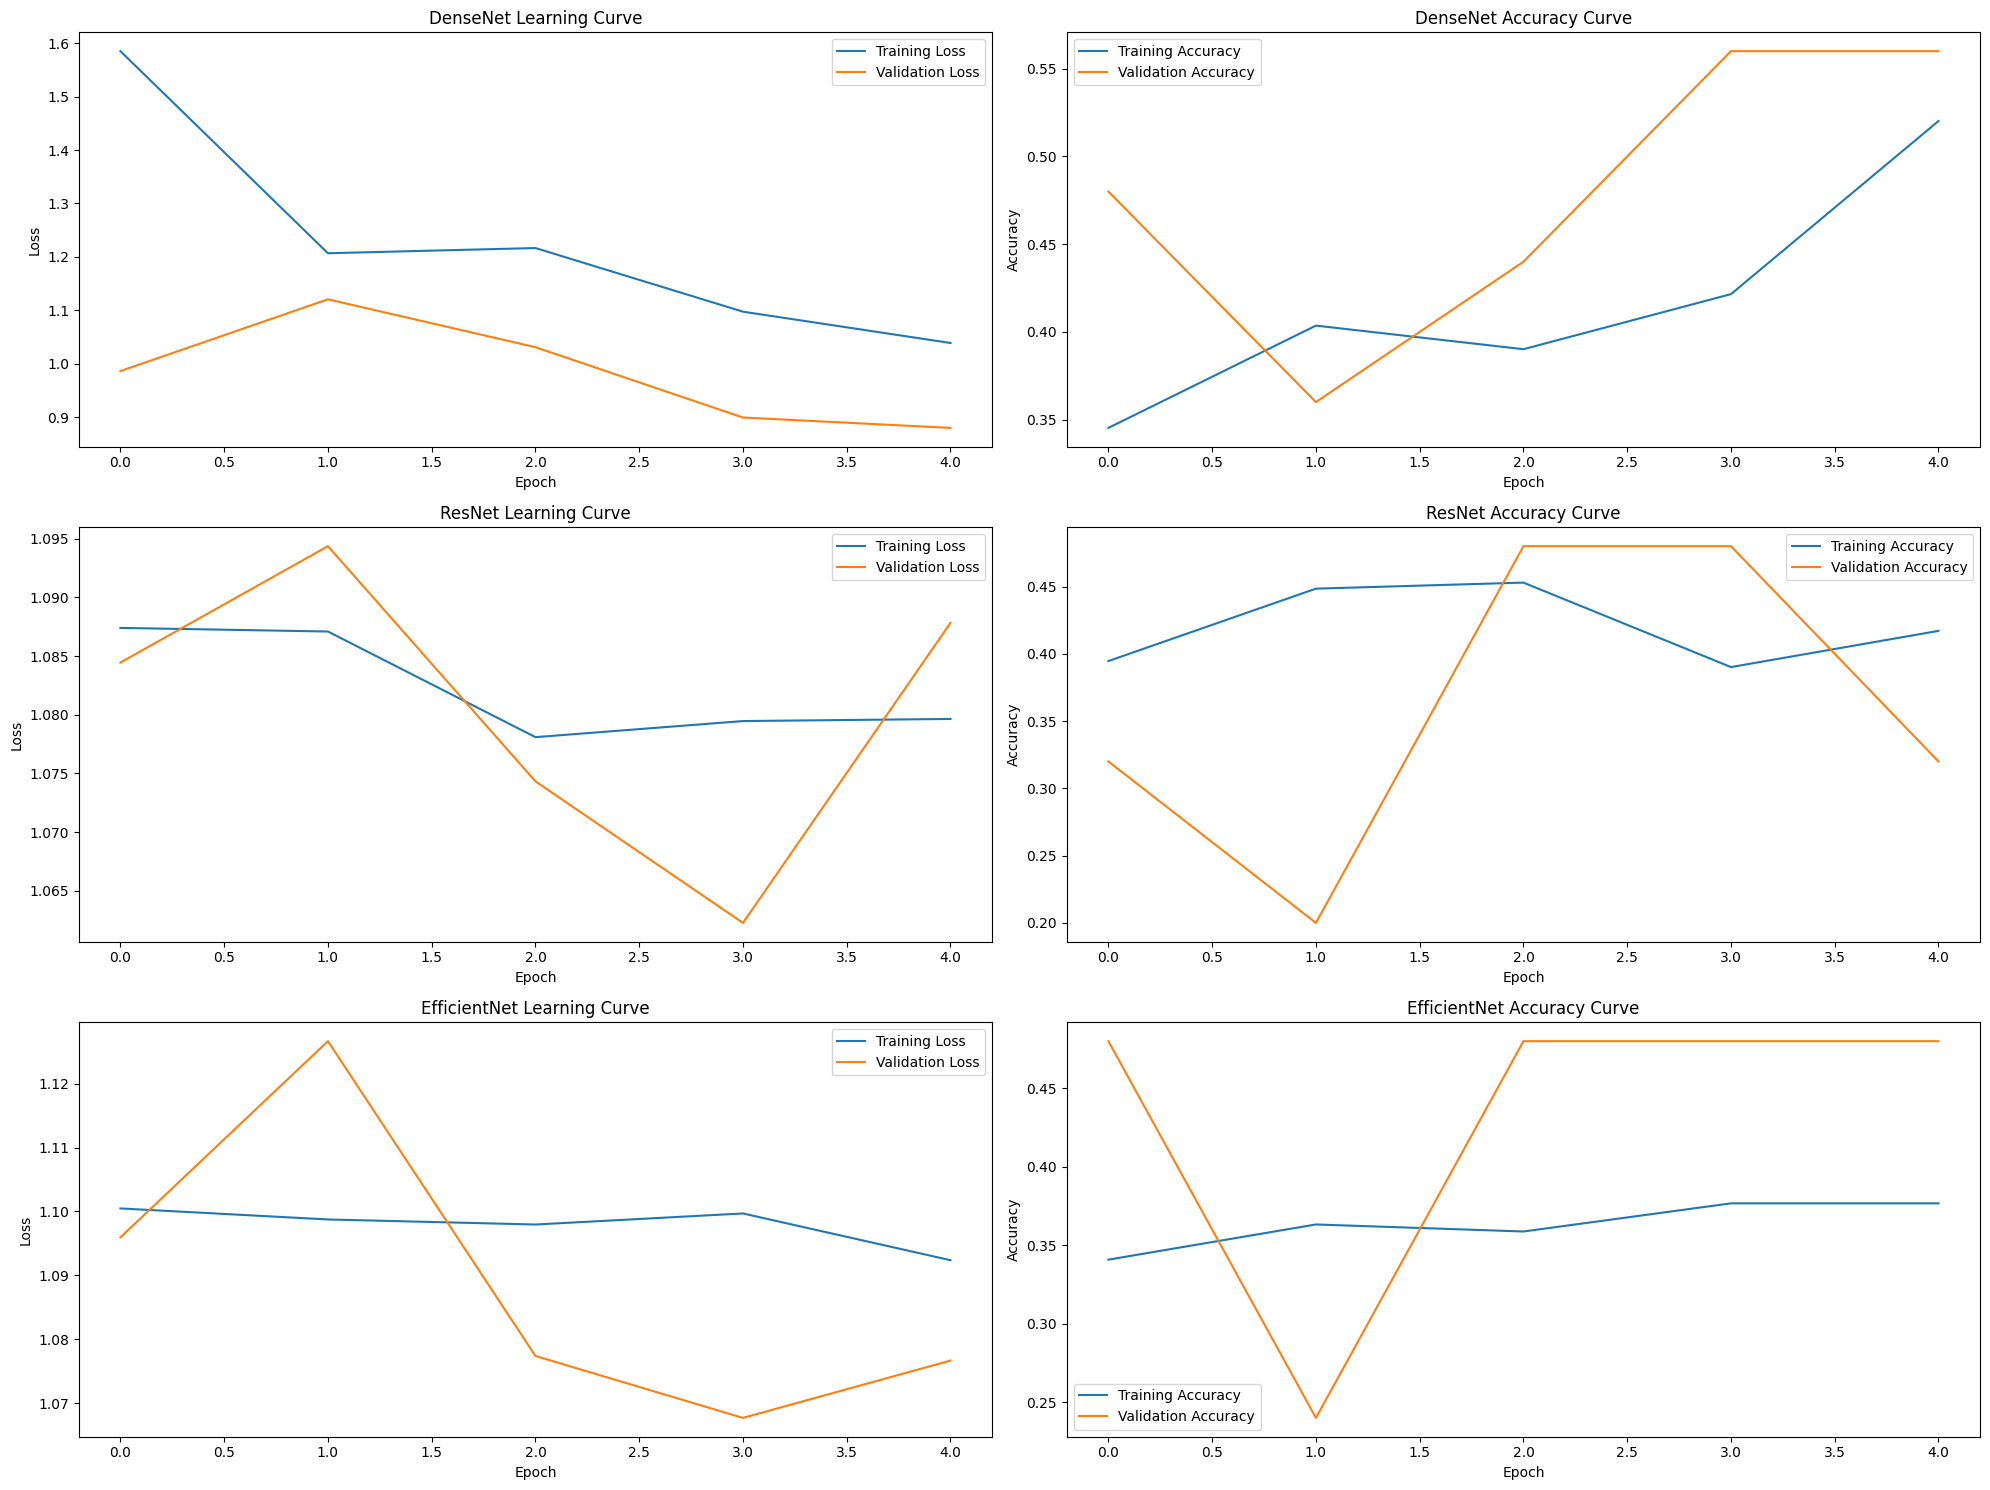

In [98]:
# Learning and Accuracy Curve Plot
import matplotlib.pyplot as plt

# Function to plot learning curves
def plot_learning_curves(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name} Learning Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

# Function to plot accuracy curves
def plot_accuracy_curves(history, model_name, ax):
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title(f'{model_name} Accuracy Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

# Utilizing functions above to plot 6 total graphs. All 3 graphs represent accuraccy and learning curves specific to each model used above
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
plot_learning_curves(densenet_history, 'DenseNet', axs[0, 0])
plot_accuracy_curves(densenet_history, 'DenseNet', axs[0, 1])

plot_learning_curves(resnet_history, 'ResNet', axs[1, 0])
plot_accuracy_curves(resnet_history, 'ResNet', axs[1, 1])

plot_learning_curves(efficientnet_history, 'EfficientNet', axs[2, 0])
plot_accuracy_curves(efficientnet_history, 'EfficientNet', axs[2, 1])

plt.tight_layout()
plt.show()

In [ ]:
############################################################################################################

In [99]:
# Save the trained model
model.save("pet_expressions_model.h5")

In [ ]:
##################################################################################
#FROM HERE DOWN IS COPIED FROM OUR SEQUENTIAL MODEL NOTEBOOK FILE. IT MAY/MAYNOT WORK FOR DEPLOYING THIS MODEL?

In [ ]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model('pet_expressions_model.h5')

In [ ]:
# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48, 48))  # Resize to a fixed size for the model
            images.append(img)
    return images

In [ ]:
# Load a custom test image
custom_test_image_path = ""

custom_test_image = cv2.imread(custom_test_image_path)
custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (48, 48))
custom_test_image = custom_test_image.astype('float32') / 255.0

In [ ]:
# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

In [ ]:
# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

In [ ]:
emotion_label = np.argmax(prediction[0])

In [ ]:
# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry', 3: 'feeling some type of way...'}
predicted_emotion = emotion_classes[emotion_label]

In [ ]:
# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry,feeling some type of way...]: {prediction_prob}")

In [ ]:
import matplotlib.pyplot as plt

#Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()